In [688]:
#pip install tweepy

# Gathering data

In [689]:
import requests
import numpy as np
import tweepy
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import json

In [690]:
folder_name = 'tweep'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
    
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)

In [691]:
 with open(os.path.join(folder_name, url.split('/')[-1]), mode='wb') as file:
        file.write(response.content)


In [692]:
os.listdir(folder_name)

['image-predictions.tsv', 'pandas.pdf']

In [693]:
"""# Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
# These are hidden to comply with Twitter's API terms and conditions
consumer_key = 'HIDDEN'
consumer_secret = 'HIDDEN'
access_token = 'HIDDEN'
access_secret = 'HIDDEN'

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

# NOTE TO STUDENT WITH MOBILE VERIFICATION ISSUES:
# df_1 is a DataFrame with the twitter_archive_enhanced.csv file. You may have to
# change line 17 to match the name of your DataFrame with twitter_archive_enhanced.csv
# NOTE TO REVIEWER: this student had mobile verification issues so the following
# Twitter API code was sent to this student from a Udacity instructor
# Tweet IDs for which to gather additional data via Twitter's API
tweet_ids = df_1.tweet_id.values
len(tweet_ids)

# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start)
print(fails_dict)  """

'# Query Twitter API for each tweet in the Twitter archive and save JSON in a text file\n# These are hidden to comply with Twitter\'s API terms and conditions\nconsumer_key = \'HIDDEN\'\nconsumer_secret = \'HIDDEN\'\naccess_token = \'HIDDEN\'\naccess_secret = \'HIDDEN\'\n\nauth = OAuthHandler(consumer_key, consumer_secret)\nauth.set_access_token(access_token, access_secret)\n\napi = tweepy.API(auth, wait_on_rate_limit=True)\n\n# NOTE TO STUDENT WITH MOBILE VERIFICATION ISSUES:\n# df_1 is a DataFrame with the twitter_archive_enhanced.csv file. You may have to\n# change line 17 to match the name of your DataFrame with twitter_archive_enhanced.csv\n# NOTE TO REVIEWER: this student had mobile verification issues so the following\n# Twitter API code was sent to this student from a Udacity instructor\n# Tweet IDs for which to gather additional data via Twitter\'s API\ntweet_ids = df_1.tweet_id.values\nlen(tweet_ids)\n\n# Query Twitter\'s API for JSON data for each tweet ID in the Twitter arc

#### Extracting data from json file

In [694]:
df =pd.DataFrame(columns =['tweet_id','retweet_count', 'favorite_count','favorited'])
with open('tweet-json.txt') as data:
    for line in data:
        extract = json.loads(line)
        tweet_id = extract['id_str']
        retweet_count = extract['retweet_count']
        favorite_count = extract['favorite_count']
        favorited = extract['favorited']
        df = df.append(pd.DataFrame([[tweet_id, retweet_count, favorite_count, favorited]], columns =['tweet_id','retweet_count', 'favorite_count','favorited']))
df = df.reset_index(drop=True)        

In [695]:
prediction =pd.read_csv('image-predictions.tsv', sep='\t')
archive =pd.read_csv('twitter-archive-enhanced.csv')

# Assessing the data

In [696]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   tweet_id        2354 non-null   object
 1   retweet_count   2354 non-null   object
 2   favorite_count  2354 non-null   object
 3   favorited       2354 non-null   object
dtypes: object(4)
memory usage: 73.7+ KB


In [697]:
df.sample(5)

,tweet_id,retweet_count,favorite_count,favorited
78,877556246731214848,3994,23258,False
2227,668248472370458624,523,1056,False
1165,721503162398597120,2124,5086,False
1495,692423280028966913,265,1618,False
1390,700062718104104960,778,2890,False


### Quality
- wrong datatypes for the two three columns object instead of int64
- wrong datatype in favorited column


In [698]:
df.retweet_count.sort_values()

290         0
1293        2
273         3
341         3
112         3
        ...  
816     52360
1077    52360
259     56625
533     56625
1037    79515
Name: retweet_count, Length: 2354, dtype: object

In [699]:
prediction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [700]:
prediction.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


## Tidy
- collapse the dog predictions into one column
- drop the prediction algorithm and the confidence of the algorithm 
- combine all tables


In [701]:
archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [702]:
archive.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1068,740373189193256964,NaN,NaN,2016-06-08 02:41:38 +0000,"<a href=""http://twitter.com/download/iphone"" r...","After so many requests, this is Bretagne. She ...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/740373189...,9,11,None,None,None,None,None
260,842892208864923648,NaN,NaN,2017-03-18 00:15:37 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Stephan. He just wants ...,8.071068e+17,4.196984e+09,2016-12-09 06:17:20 +0000,https://twitter.com/dog_rates/status/807106840...,13,10,Stephan,None,None,None,None
1316,706644897839910912,NaN,NaN,2016-03-07 00:57:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Shadow. She's tired of the responsibiliti...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/706644897...,9,10,Shadow,None,None,None,None
263,842535590457499648,NaN,NaN,2017-03-17 00:38:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Winnie. She lost her body saving a chi...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/842535590...,13,10,Winnie,None,None,None,None
42,884247878851493888,NaN,NaN,2017-07-10 03:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",OMG HE DIDN'T MEAN TO HE WAS JUST TRYING A LIT...,NaN,NaN,NaN,https://twitter.com/kaijohnson_19/status/88396...,13,10,None,None,None,None,None


##  Quality
- missing values (in-reply-to-status, in-reply to-user, retweeted-status-user-id,
  expanded_urls, retweeted-status-timestamp, retweeted-status-id)
- missing values as none in the doggo floofer pupper and puppo
- missing values presented as none in name column 
- duplicated entry for  sierra, cooper
- remove retweets in the dataset
- wrong data type for tweet_id


## Tidiness

- combine df with  prediction data set


In [703]:
archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [704]:
all_columns = pd.Series(list(df) + list(prediction) + list(archive))

In [705]:
all_columns[all_columns.duplicated()]

4     tweet_id
16    tweet_id
dtype: object

# Clean

##  Quality
- missing values (in-reply-to-status, in-reply to-user, retweeted-status-user-id,
  expanded_urls, retweeted-status-timestamp, retweeted-status-id)
- missing values as none in the doggo floofer pupper and puppo
- missing values presented as none in name column 
- wrong datatypes for the first two columns of df object instead of int64
- wrong datatype in favorited column
- remove retweets 
- remove missing data  for expanded_urls
- wrong datatype for tweet_id in archive

## Tidy
- collapse the dog predictions into one column
- drop the prediction algorithm and the confidence of the algorithm (p1,  p1_conf, p1_dog,  p2, p2_conf, p2_dog, p3, p3_conf,     p3_dog ) 
- combine the tweet, arch and pred since they have same observation
- put the dog stages(puppo , fooler, pupper) into one column


##### copying the dataframes

In [706]:
arch = archive.copy()
pred = prediction.copy()
tweet = df.copy()

In [707]:
arch.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

# define

 - drop retweets and missind expanded_urls

## Code

In [708]:
arch= arch[arch.retweeted_status_id.isnull()]

arch = arch[arch.retweeted_status_user_id.isnull()]

arch = arch[arch.retweeted_status_timestamp.isnull()]

arch= arch[arch.expanded_urls.notna()]

## test

In [709]:
arch.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2117 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2117 non-null   int64  
 1   in_reply_to_status_id       23 non-null     float64
 2   in_reply_to_user_id         23 non-null     float64
 3   timestamp                   2117 non-null   object 
 4   source                      2117 non-null   object 
 5   text                        2117 non-null   object 
 6   retweeted_status_id         0 non-null      float64
 7   retweeted_status_user_id    0 non-null      float64
 8   retweeted_status_timestamp  0 non-null      object 
 9   expanded_urls               2117 non-null   object 
 10  rating_numerator            2117 non-null   int64  
 11  rating_denominator          2117 non-null   int64  
 12  name                        2117 non-null   object 
 13  doggo                       2117 

## define
- drop the columns; in_reply_to_status_id,  in_reply_to_user_id,  retweeted_status_id, retweeted_status_user_id,   retweeted_status_timestamp


# code

In [710]:
arch = arch.drop('in_reply_to_status_id', axis=1)
arch = arch.drop('in_reply_to_user_id', axis=1)

In [711]:
arch = arch.drop('retweeted_status_id', axis=1)
arch = arch.drop('retweeted_status_user_id', axis=1)
arch = arch.drop('retweeted_status_timestamp', axis=1)


# test

In [712]:
arch.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2117 entries, 0 to 2355
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            2117 non-null   int64 
 1   timestamp           2117 non-null   object
 2   source              2117 non-null   object
 3   text                2117 non-null   object
 4   expanded_urls       2117 non-null   object
 5   rating_numerator    2117 non-null   int64 
 6   rating_denominator  2117 non-null   int64 
 7   name                2117 non-null   object
 8   doggo               2117 non-null   object
 9   floofer             2117 non-null   object
 10  pupper              2117 non-null   object
 11  puppo               2117 non-null   object
dtypes: int64(3), object(9)
memory usage: 215.0+ KB


## define 
- combine the dog stage (floofer doggo, puppo, pupper) into one column named stage

## code

In [713]:
arch.doggo.replace('None', '', inplace = True)
arch.floofer.replace('None', '', inplace = True)
arch.puppo.replace('None', '', inplace = True)
arch.pupper.replace('None', '', inplace = True)

In [714]:
arch['stage'] = arch.text.str.extract('(doggo|floofer|pupper|puppo)', expand = True)


In [715]:
arch['stage'] = arch.doggo + arch.floofer + arch.pupper + arch.puppo
arch.loc[arch.stage == 'doggopupper', 'stage'] = 'doggo,pupper' 
arch.loc[arch.stage == 'doggopuppo', 'stage'] = 'doggo,puppo' 
arch.loc[arch.stage == 'doggofloofer', 'stage'] = 'doggo,floofer'


In [716]:
arch.sample(5)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,stage
1050,743210557239623680,2016-06-15 22:36:19 +0000,"<a href=""http://twitter.com/download/iphone"" r...","Meet Kayla, an underground poker legend. Playe...",https://twitter.com/dog_rates/status/743210557...,10,10,Kayla,,,,,
1024,746507379341139972,2016-06-25 00:56:43 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Shiloh. She did not pass the soft mout...,https://twitter.com/dog_rates/status/746507379...,10,10,Shiloh,,,,,
1486,693109034023534592,2016-01-29 16:30:45 +0000,"<a href=""http://twitter.com/download/iphone"" r...","""Thank you friend that was a swell petting"" 11...",https://twitter.com/dog_rates/status/693109034...,11,10,None,,,,,
2206,668631377374486528,2015-11-23 03:25:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Zeek. He is a grey Cumulonimbus. Zeek is ...,https://twitter.com/dog_rates/status/668631377...,5,10,Zeek,,,,,
1996,672591762242805761,2015-12-04 01:42:26 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Taz. He boxes leaves. 10/10 https://t....,https://twitter.com/dog_rates/status/672591762...,10,10,Taz,,,,,


## Define
-drop doggo floofer pupper puppo column

## code

In [717]:
arch.drop(['doggo','floofer','pupper','puppo'], axis=1, inplace = True)


## test

In [718]:
arch.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2117 entries, 0 to 2355
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            2117 non-null   int64 
 1   timestamp           2117 non-null   object
 2   source              2117 non-null   object
 3   text                2117 non-null   object
 4   expanded_urls       2117 non-null   object
 5   rating_numerator    2117 non-null   int64 
 6   rating_denominator  2117 non-null   int64 
 7   name                2117 non-null   object
 8   stage               2117 non-null   object
dtypes: int64(3), object(6)
memory usage: 165.4+ KB


## define
changing datatypes

## code

In [719]:
tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   tweet_id        2354 non-null   object
 1   retweet_count   2354 non-null   object
 2   favorite_count  2354 non-null   object
 3   favorited       2354 non-null   object
dtypes: object(4)
memory usage: 73.7+ KB


In [738]:
convert = {
    'retweet_count': int,
    'favorite_count': int,
    'favorited': bool
}
bird = {'tweet_id': object}

In [739]:
tweet = tweet.astype(convert)
arch = arch.astype(bird)
pred = pred.astype(bird)

## test

In [740]:
tweet.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   tweet_id        2354 non-null   object
 1   retweet_count   2354 non-null   int32 
 2   favorite_count  2354 non-null   int32 
 3   favorited       2354 non-null   bool  
dtypes: bool(1), int32(2), object(1)
memory usage: 39.2+ KB


In [723]:
arch.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2117 entries, 0 to 2355
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            2117 non-null   object
 1   timestamp           2117 non-null   object
 2   source              2117 non-null   object
 3   text                2117 non-null   object
 4   expanded_urls       2117 non-null   object
 5   rating_numerator    2117 non-null   int64 
 6   rating_denominator  2117 non-null   int64 
 7   name                2117 non-null   object
 8   stage               2117 non-null   object
dtypes: int64(2), object(7)
memory usage: 165.4+ KB


## define 
- create a column to store the values of a all the predictions
- drop prediction confidence and algorithms cloumns(  p1,  p1_conf, p1_dog,  p2, p2_conf, p2_dog, p3, p3_conf, p3_dog )

## code

In [724]:
pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   object 
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 152.1+ KB


In [725]:
dog =[]
for predt in range(2075):
    if prediction['p1_dog'][predt]:
        dog.append("p1_dog")
    elif prediction['p2_dog'][predt]:
        dog.append("p2_dog")
    elif prediction['p3_dog'][predt]:
        dog.append("p3_dog")
    else:
        dog.append("no prediction")
        
pred['dog'] = dog

In [726]:
pred = pred.drop(['p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog'], axis= 1)

In [727]:
pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   tweet_id  2075 non-null   object
 1   jpg_url   2075 non-null   object
 2   img_num   2075 non-null   int64 
 3   dog       2075 non-null   object
dtypes: int64(1), object(3)
memory usage: 65.0+ KB


## define
- merge tweet arch and pred 


## code

In [749]:
clean = pd.merge(tweet, pred, on = 'tweet_id')
df_clean = pd.merge(clean, arch, on = ['tweet_id'])

## test

In [750]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   retweet_count       0 non-null      int32 
 1   favorite_count      0 non-null      int32 
 2   favorited           0 non-null      bool  
 3   jpg_url             0 non-null      object
 4   img_num             0 non-null      int64 
 5   dog                 0 non-null      object
 6   tweet_id            0 non-null      object
 7   timestamp           0 non-null      object
 8   source              0 non-null      object
 9   text                0 non-null      object
 10  expanded_urls       0 non-null      object
 11  rating_numerator    0 non-null      int64 
 12  rating_denominator  0 non-null      int64 
 13  name                0 non-null      object
 14  stage               0 non-null      object
dtypes: bool(1), int32(2), int64(3), object(9)
memory usage: 0.0+ bytes


In [730]:
bird = {'tweet_id': object,
       'timestamp': 'datetime64[ns]',
       'favorited': bool}                                ### changing datatypes after merging to its correct datatype
df_clean = df_clean.astype(bird)

# Visualization and analysis

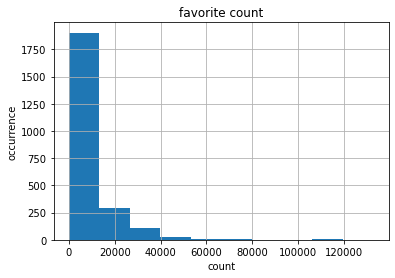

In [731]:
df_clean['favorite_count'].hist()
plt.title('favorite count')
plt.xlabel('count')
plt.ylabel('occurrence');

- Using a histogram to visualize the distribution of data.

### checking how many images where actually dogs

In [732]:
unpredict = df_clean[df_clean['dog']=='no prediction']
predict = df_clean[df_clean['dog']!='no prediction']

In [733]:
ser1 = unpredict['dog'].count()
ser2 = predict['dog'].count()

In [734]:
predictions =(ser2/(ser1+ ser2))* 100

In [735]:
predictions

84.3855421686747

 - Out of all the images the prediction algorithm was able to predict 84% of the images 

## using describe to explore the data

In [736]:
df_clean.describe()

,rating_numerator,rating_denominator,retweet_count,favorite_count,img_num
count,2117.000000,2117.000000,2354.000000,2354.000000,2075.000000
mean,12.246103,10.501181,3164.797366,8080.968564,1.203855
std,40.275298,7.105845,5284.770364,11814.771334,0.561875
min,0.000000,2.000000,0.000000,0.000000,1.000000
25%,10.000000,10.000000,624.500000,1415.000000,1.000000
50%,11.000000,10.000000,1473.500000,3603.500000,1.000000
75%,12.000000,10.000000,3652.000000,10122.250000,1.000000
max,1776.000000,170.000000,79515.000000,132810.000000,4.000000


- maximum rating_numerator in the dataset 1776
- The average rating numerator is 12.25 (rounded up to two decimal places)
- The highest retweet count was 79515 but on average a retweet count was 3165 (to the nearest whole number)

### store in csv

In [737]:
df_clean = clean.to_csv('df_clean.csv',  index = False)